In [7]:
# suppress deprecation warnings
import logging
import torch

logging.captureWarnings(True)

# set correct torch device
if not torch.backends.mps.is_available():
    if not torch.backends.mps.is_built():
        print("MPS not available because the current PyTorch install was not "
              "built with MPS enabled.")
    else:
        print("MPS not available because the current MacOS version is not 12.3+ "
              "and/or you do not have an MPS-enabled device on this machine.")

elif torch.backends.mps.is_available():
    DEVICE = 'mps'

elif torch.cuda.is_available():
    DEVICE = 'cuda'

else:
    DEVICE = 'cpu'

print(f"Using device: {DEVICE}")


Using device: mps


In [10]:
import numpy as np
import pandas as pd

from tabpfniml.datasets.datasets import ArrayData

from tabpfniml.methods.ale import ALE
from tabpfniml.methods.ice_pd import ICE_PD
from tabpfniml.methods.conformal_pred import Conformal_Prediction
from tabpfniml.methods.dca import DCA
from tabpfniml.methods.loco import LOCO
from tabpfniml.methods.sensitivity import Sensitivity
from tabpfniml.methods.kernel_shap import SHAP
from tabpfniml.methods.counterfactuals import Counterfactuals


Retrieve the pima diabetes dataset which we will use as a binary classification task to predict whether a patient has diabetes. 

This dataset is originally from the National Institute of Diabetes and Digestive and Kidney Diseases. The objective of the dataset is to diagnostically predict whether or not a patient has diabetes, based on certain diagnostic measurements included in the dataset. Several constraints were placed on the selection of these instances from a larger database. In particular, all patients here are females at least 21 years old of Pima Native American heritage. The datasets consists of several medical predictor variables and one target variable, Outcome. Predictor variables includes the number of pregnancies the patient has had, their BMI, insulin level, age, and so on.



*Acknowledgement* 

Smith, J.W., Everhart, J.E., Dickson, W.C., Knowler, W.C., & Johannes, R.S. (1988). Using the ADAP learning algorithm to forecast the onset of diabetes mellitus. In Proceedings of the Symposium on Computer Applications and Medical Care (pp. 261--265). IEEE Computer Society Press.

In [11]:
diabetes = pd.read_csv('https://raw.githubusercontent.com/npradaschnor/Pima-Indians-Diabetes-Dataset/master/diabetes.csv')

X = diabetes.drop(columns='Outcome')
y = diabetes['Outcome'] 

diabetes_data = ArrayData("diabetes", X, y, categorical_features_idx=[0], feature_names=X.columns, id_to_target_name={1: 'Diabetes'})
diabetes_data.id_to_target_name = {1: 'Diabetes'}

In [12]:
diabetes_data.X_df.head(10)

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age
0,6,148,72,35,0,33.6,0.627,50
1,1,85,66,29,0,26.6,0.351,31
2,8,183,64,0,0,23.3,0.672,32
3,1,89,66,23,94,28.1,0.167,21
4,0,137,40,35,168,43.1,2.288,33
5,5,116,74,0,0,25.6,0.201,30
6,3,78,50,32,88,31.0,0.248,26
7,10,115,0,0,0,35.3,0.134,29
8,2,197,70,45,543,30.5,0.158,53
9,8,125,96,0,0,0.0,0.232,54


In [13]:
N_TRAIN = round(0.8 * diabetes_data.X_df.shape[0])
N_TEST = round(0.2 * diabetes_data.X_df.shape[0])

FEATURE_ID_OF_INTEREST = 1

### ICE and PD plots
We not use the `ICE_PD` class of our package to initialize, fit and plot the Individual Conditional Expectation (ICE) curves in black as well as their average, the Partial Dependence (PD) plot in orange for our feature of interest, the blood glucose levels in mg/dl.


ICE curves are a local method that indicates the change in the model prediction for an individual along the features space of a feature of interest when all other features are held constant. A limitation of ICE and PD plots is that the generated artificial observations can be out-of-distribution if two features are correlated, meaning the model would need to ex- trapolate.

It is evident that the model is more inclined to predict individuals as diabetic if their blood glucose level exceeds approximately 140 mg/dl.

Loading model that can be used for inference only
Using a Transformer with 25.82 M parameters


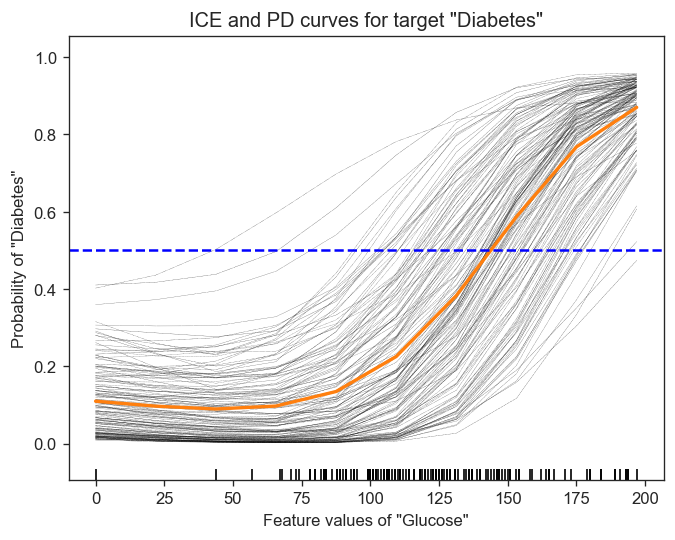

In [15]:
icepd = ICE_PD(diabetes_data,
               n_train=N_TRAIN,
               n_test=N_TEST,
               device=DEVICE)
icepd.fit(features=[FEATURE_ID_OF_INTEREST],
          max_levels_per_feature=10)
icepd.plot(features=[FEATURE_ID_OF_INTEREST])

### ALE plots
We now use the `ALE` class of our package to initialize, fit and plot the Accumulated Local Effects (ACE) curve for our feature of interest, the blood glucose levels in mg/dl.

ALE plots are a global method that deal with the extrapolation issue that can be present for correlated features in the PD plot. They show the accumulated effect of each feature by adding up local effects for finite intervals along the feature space of a feature of interest.

While we can not directly interpret the y-axis of the ALE plot as a probability, we can still see a very similar effect to the PD plot above.

Loading model that can be used for inference only
Using a Transformer with 25.82 M parameters


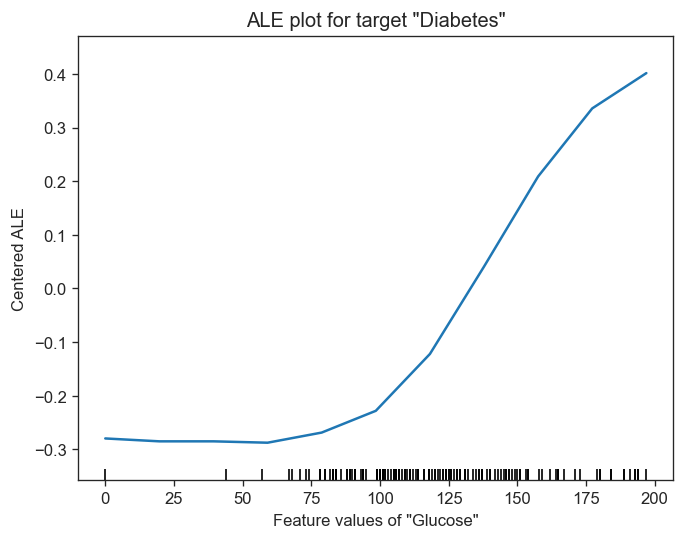

In [10]:
ale_obj = ALE(diabetes_data,
              n_train=N_TRAIN,
              n_test=N_TEST,
              device=DEVICE)
ale_obj.fit(features=[FEATURE_ID_OF_INTEREST],
            discretize_by_linear_spacing=True,
            center=True,
            max_intervals_per_feature=10)
ale_obj.get_ALE(feature=FEATURE_ID_OF_INTEREST)
ale_obj.plot(features=[FEATURE_ID_OF_INTEREST])

### LOCO
Leave-one-covariate-out (LOCO) is a global feature importance measure. It estimates the e↵ect of features on the predictive performance by retraining the model on a subset of features without the feature of interest. A positive value indicates that the feature improves the performance, since excluding it has led to an increase in the loss. Conversely, a very small value suggests that the feature may not be important and a negative value suggests that the feature may even have a detrimental effect on the model performance. LOCO approximately indicates if a learner requires access to a feature in the sense that the feature contains unique information that no other feature in the dataset contains.

In the plot below we can see that the blood glucose level seems to be important for TabPFN on this classification task, whereas the inclusion of the skin thickness measurements might have an adverse effect of TabPFN's performance on this task.

Loading model that can be used for inference only
Using a Transformer with 25.82 M parameters


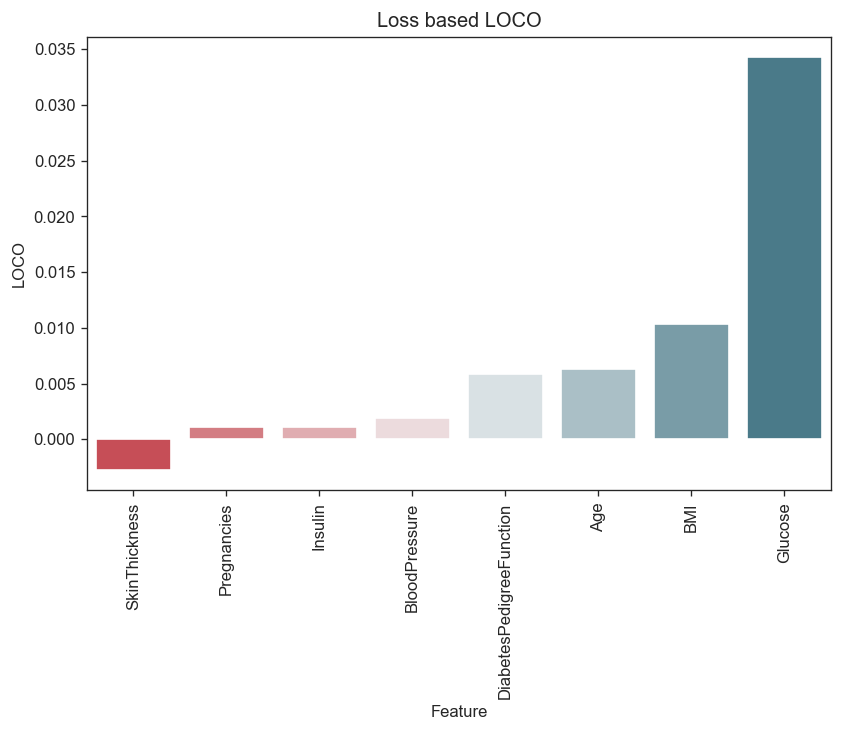

In [11]:
loco_obj = LOCO(diabetes_data,
                n_train=N_TRAIN,
                n_test=N_TEST,
                device=DEVICE)
loco_obj.fit()
loco_obj.plot_bar()

### Sensitivity
The Sensitivity class implements a gradient-based sensitivity analysis method, designed to interpret the behavior of TabPFN by evaluating how changes in input features or training samples affect the model's predictions or performance. It enables the analysis of both feature importance and training sample influence.

In [7]:
sens_obj = Sensitivity(diabetes_data,
                       n_train=N_TRAIN,
                       n_test=N_TEST,
                       device=DEVICE)
sens_obj.fit(compute_wrt_feature=True,
             compute_wrt_observation=True,
             loss_based=True,
             pred_based=True)

Loading model that can be used for inference only
Using a Transformer with 25.82 M parameters


Boxplot of local feature effects:

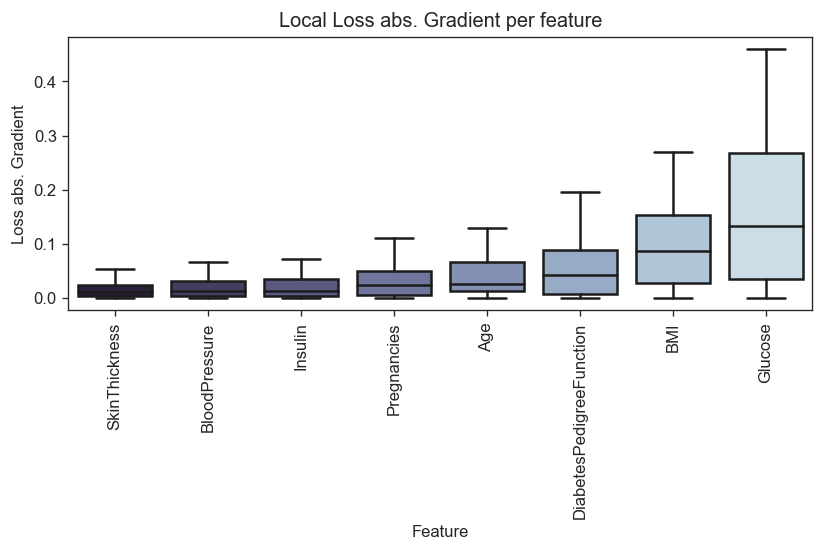

In [8]:
sens_obj.boxplot()

Here, we can see a histogram of local observation effects, showing the frequency of the sensitivity of predictions with respect to training observations.

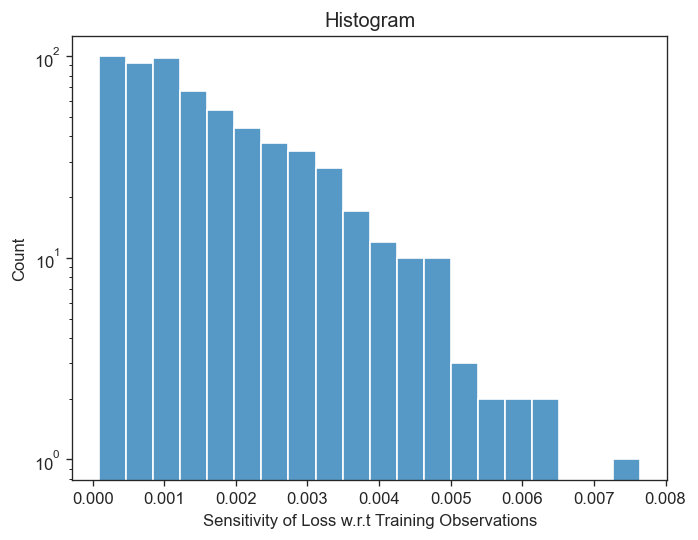

In [9]:
sens_obj.plot_histogram(plot_wrt_observation=True)

### Shapley & KernelSHAP

Shapley values were first introduced in the context of cooperative game theory to distribute the total payoff of a game to its players based on their contribution. In the context of machine learning, the “game” is the prediction task, “players” are the input features, and the “payoff” is the prediction. Kernel SHAP (SHapley Additive exPlanations) is a method that approximates Shapley values in a computationally more efficient manner. It aims at finding an additive combination of the marginal feature contributions for all features at once and employs a more efficient estimation procedure.

Below we can see the global SHAP values as a barplot. The x-axis corresponds to the features and the y-axis describes the associated global SHAP values.

Loading model that can be used for inference only
Using a Transformer with 25.82 M parameters


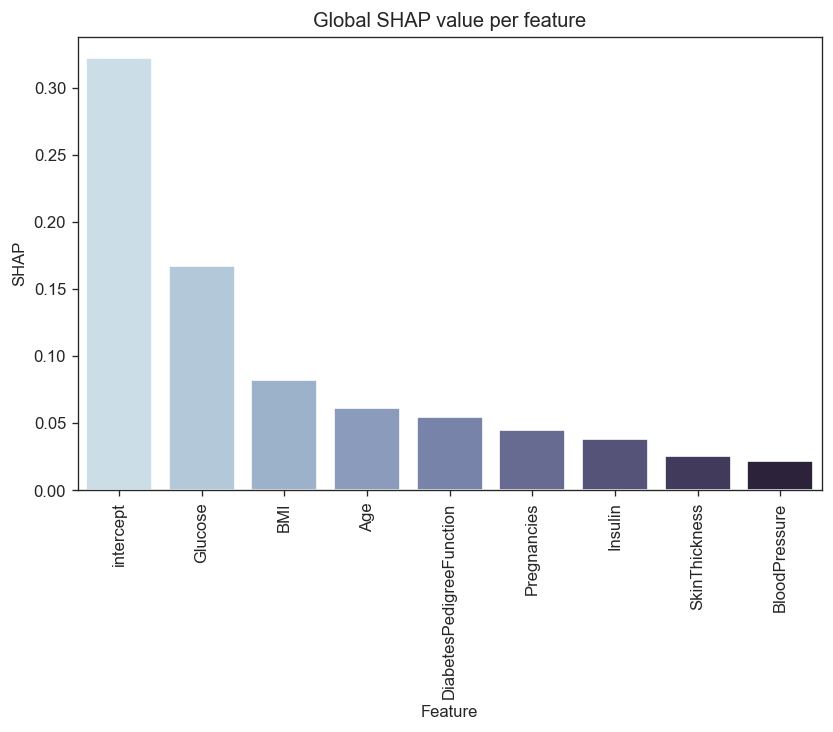

In [12]:
shap_obj = SHAP(diabetes_data,
                n_train=N_TRAIN,
                n_test=N_TEST,
                device=DEVICE)
shap_obj.fit()
shap_obj.plot_bar()

### Counterfactual Explanations
Counterfactual explanations cannot be directly classified as feature effects or feature importance method, but are categorized as local explanations. The key idea of counterfactuals is to figure out how the features of a certain observation need to change such that the model would predict the opposing class. In other words, it is about finding a true or artificial observation that indicates the minimal changes necessary in the features of a factual observation for the model to predict a desired class.

Details on the different objectives can be found in Dandl et al. (2020): https://link.springer.com/chapter/10.1007/978-3-030-58112-1_31

In this example, the population is initialized based on the test-set, often leading to better plausibility of the returned CEs.

In [13]:
ce_obj = Counterfactuals(diabetes_data,
                         n_train=N_TRAIN,
                         n_test=N_TEST,
                         device=DEVICE)
ce_obj.fit(init_based_on_test_set=True,
            test_index_factual=0,
            population_size=1000, 
            offsprings_size=500)
ce_obj.get_counterfactuals(first_n=5)

Loading model that can be used for inference only
Using a Transformer with 25.82 M parameters
(1000, 8)

Compiled modules for significant speedup can not be used!
https://pymoo.org/installation.html#installation

To disable this warning:
from pymoo.config import Config
Config.warnings['not_compiled'] = False

(500, 8)
(500, 8)
(500, 8)
(500, 8)
(500, 8)
(500, 8)
(500, 8)
(500, 8)
(500, 8)
(500, 8)


Objectives                                    Features          \
          Prediction Closeness Sparsity Plausibility Pregnancies Glucose   
x_factual        1.0  0.000000      0.0     0.000000         7.0   159.0   
CE 1             0.0  0.048820      4.0     0.021052         7.0   140.0   
CE 2             0.0  0.053879      4.0     0.019926         7.0   134.0   
CE 3             0.0  0.025074      3.0     0.026252         7.0   142.0   
CE 4             0.0  0.065415      5.0     0.011283         7.0   140.0   
CE 5             0.0  0.176945      6.0     0.008274        10.0   114.0   

                                                                              \
          BloodPressure SkinThickness Insulin   BMI DiabetesPedigreeFunction   
x_factual          64.0           0.0     0.0  27.4                    0.294   
CE 1               64.0           0.0     0.0  26.1                    0.207   
CE 2               64.0           0.0     0.0  24.1                    0.247   
CE 3               64.0           0.0     0.0  27.4                    0.126   
CE 4               84.0           0.0     0.0  29.7                    0.207   
CE 5               68.0           0.0     0.0  33.3                    0.258   

                 
            Age  
x_factual  40.0  
CE 1       54.0  
CE 2       54.0  
CE 3       42.0  
CE 4       51.0  
CE 5       42.0

Alternatively, one can also initialize the population by mutating around the observation that a CE is searched for. This often leads to higher sparsity and closeness of the returnes CEs. We can also specify that certain features should not differ from the value in the factual observation; for this example we chose the feature age.

In [7]:
ce_obj_na = Counterfactuals(diabetes_data,
                            n_train=N_TRAIN,
                            n_test=N_TEST)
ce_obj_na.fit(init_based_on_test_set=False,
            test_index_factual=0,
            population_size=1000, 
            offsprings_size=500,
            non_actionable_features=['Age'])
ce_obj_na.get_counterfactuals(first_n=5)

Loading model that can be used for inference only
Using a Transformer with 25.82 M parameters
(13069, 8)

Compiled modules for significant speedup can not be used!
https://pymoo.org/installation.html#installation

To disable this warning:
from pymoo.config import Config
Config.warnings['not_compiled'] = False

(500, 8)
(500, 8)
(500, 8)
(500, 8)
(500, 8)
(500, 8)
(500, 8)
(500, 8)
(500, 8)
(500, 8)


Objectives                                 Non-actionable Features  \
          Prediction Closeness Sparsity Plausibility                     Age   
x_factual        1.0  0.000000      0.0     0.000000                    40.0   
CE 1             0.0  0.010897      1.0     0.031605                    40.0   
CE 2             0.0  0.094903      3.0     0.014446                    40.0   
CE 3             0.0  0.014744      1.0     0.031100                    40.0   
CE 4             0.0  0.079645      3.0     0.017409                    40.0   
CE 5             0.0  0.134615      2.0     0.015287                    40.0   

          Actionable Features                                              \
                  Pregnancies Glucose BloodPressure SkinThickness Insulin   
x_factual                 7.0   159.0          64.0           0.0     0.0   
CE 1                      7.0   142.0          64.0           0.0     0.0   
CE 2                      7.0    61.0          84.0           0.0     0.0   
CE 3                      7.0   136.0          64.0           0.0     0.0   
CE 4                      7.0    61.0          64.0           0.0     0.0   
CE 5                      4.0   144.0          64.0           0.0     0.0   

                                          
            BMI DiabetesPedigreeFunction  
x_factual  27.4                    0.294  
CE 1       27.4                    0.294  
CE 2       32.5                    0.294  
CE 3       27.4                    0.294  
CE 4       32.5                    0.388  
CE 5       27.4                    0.294

### Decision Curve Analysis
Decision Curve Analysis (DCA) is a method designed to evaluate the clinical benefits of diagnostic tests, predictive models, and decision-making strategies. Unlike traditional metrics that focus solely on the accuracy or predictive ability of a model, DCA incorporates the real-world impact of decision-making by considering the preferences and outcomes relevant to patients and healthcare providers. It does this by plotting a decision curve that illustrates the net benefit of a diagnostic test or treatment strategy across a range of threshold probabilities. In our implementation, TabPFN can be compared to a logistic regression model fit on the `marker`-feature and to other machine learning models, such as a scikit-learn `RandomForestClassifier`.

The threshold probability represents the point at which a patient or clinician would opt for treatment versus observation, balancing the risks of unnecessary intervention against the risks of not treating a condition. By comparing the net benefits of different strategies at these thresholds, DCA helps in identifying which diagnostic or treatment approach maximizes patient benefit. This analysis is particularly useful in clinical settings where decisions must consider both the potential benefits and harms of interventions, making it a valuable tool for guiding evidence-based clinical decision-making.

Loading model that can be used for inference only
Using a Transformer with 25.82 M parameters


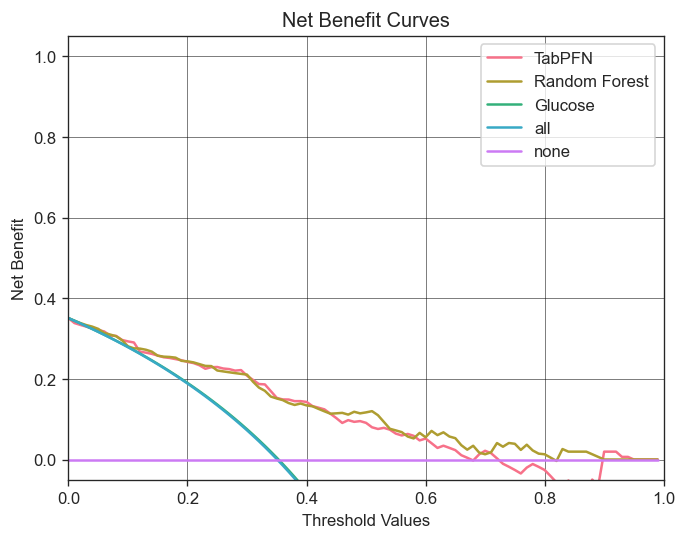

In [16]:
dca_obj = DCA(diabetes_data,
              n_train=N_TRAIN,
              n_test=N_TEST,
              device=DEVICE)
dca_obj.fit(marker=X.columns[FEATURE_ID_OF_INTEREST],
            random_forest=True)
dca_obj.plot(predictors=["TabPFN", "Random Forest",
                         X.columns[FEATURE_ID_OF_INTEREST]])

### Conformal Prediction
Conformal prediction is a statistical technique that produces prediction intervals (or sets) that are valid under minimal assumptions about the data. Unlike traditional point predictions, conformal prediction quantifies the uncertainty of its predictions by providing a range of possible outcomes with a specified confidence level, given by a list of alphas: `alphas`.

Plotting our feature of interest, the blood glucose level, on the y-axis against the number of pregnancies on the x-axis, we can see that with a higher confidence level, i.e., a lower alpha, we get more than one assigned label in the prediction set for observations, where the glucose levels are in the neighborhood of 140 mg/dl, so close to the decision boundary of TabPFN.

Loading model that can be used for inference only
Using a Transformer with 25.82 M parameters


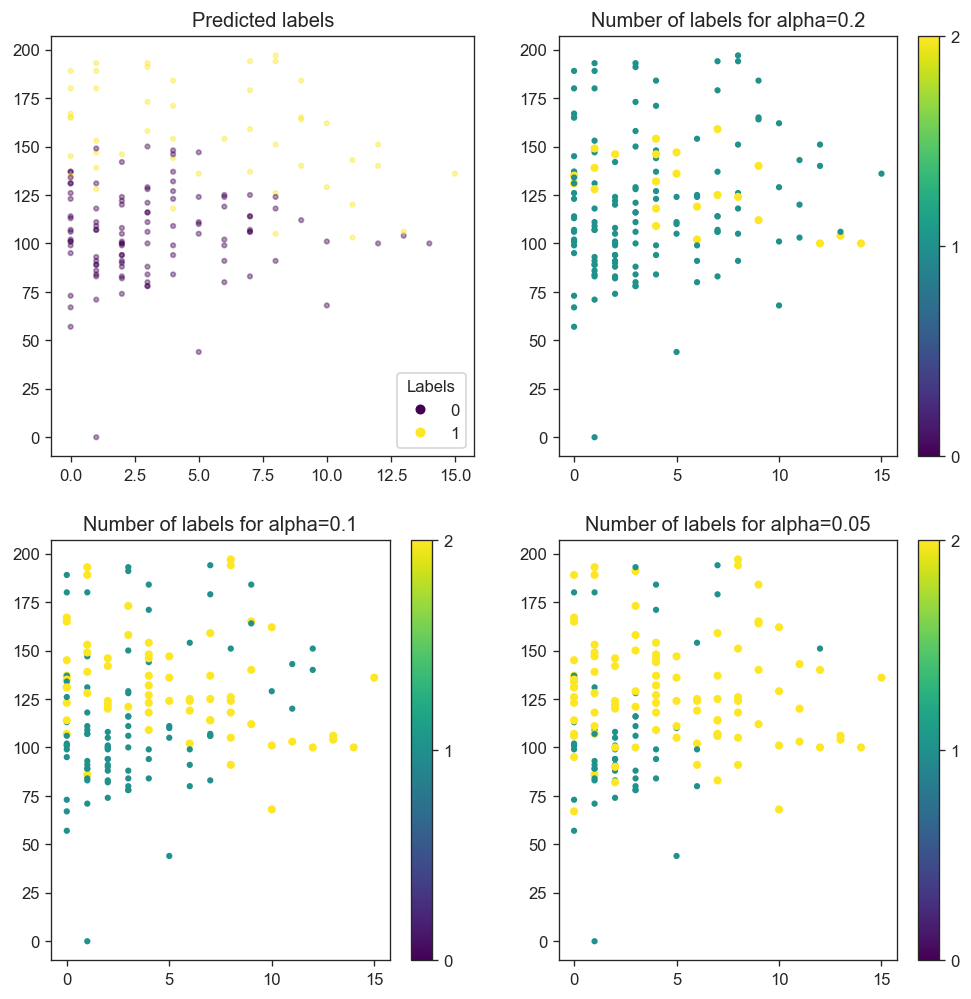

In [ ]:
cp_obj = Conformal_Prediction(diabetes_data,
                              n_train=N_TRAIN,
                              n_test=N_TEST, 
                              device=DEVICE)
cp_obj.fit()
cp_obj.plot(alphas=[0.2, 0.1, 0.05])